In [1]:
from collections import namedtuple
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from linesearchers.np.graphs import quadratics
from linesearchers.np import run

### Line Search with TensorFlow and NumPy

One approach to implementing line search is to use TensorFlow just as an automatic differentiation package, using it to compute all of the quantities necessary to determine the search direction, then using numpy to perform the line search.

The primary disadvantage of this method is that it is slow. The primary advantage is that it is easier to write than a pure TensorFlow approach.

### Gradient Descent with Line Search

For gradient descent, the search direction is just the negative of the gradient. This method performs best on well-conditioned quadratic surfaces, but can run very slowly on ill-conditioned surfaces.

In [2]:
matrix = np.asarray([[1000.,0.],[0.,1.]]).astype(np.float32)
initial_values = quadratics.generate_initial_values(2)

btls_gd_args = {"method": "gradient_descent",
                "beta":0.5,
                "alpha" : 0.49,
                "num_steps": 25,
                "max_backtrack" : 10}

run.btls(matrix, initial_values, **btls_gd_args)

{'final_f': 1.5364059,
 'initial_f': 16.897175,
 'initial_values': array([-0.18380417, -0.10185488], dtype=float32),
 'solution': array([ 0.05534802, -0.09699631], dtype=float32),
 'steps_run': 25,
 'sufficient_decrease': True}

### Newton Method with Line Search

For the Newton Method, the search direction is the inverse of the Hessian times the gradient. This method does well even on poorly-conditioned positive-definite quadratic surfaces.

In [3]:
matrix = np.asarray([[1000.,0.],[0.,1.]]).astype(np.float32)
initial_values = quadratics.generate_initial_values(2)

btls_newton_args = {"method": "newton",
                "beta":0.5,
                "alpha" : 0.49,
                "num_steps": 1,
                "max_backtrack" : 10}

run.btls(matrix, initial_values, **btls_newton_args)

{'final_f': 0.0,
 'initial_f': 180.3801,
 'initial_values': array([0.600624  , 0.10475361], dtype=float32),
 'solution': array([0., 0.], dtype=float32),
 'steps_run': 1,
 'sufficient_decrease': True}

But Newton's Method with line search sometimes fails to make progress on non-convex (non-singular, indefinite) quadratic surfaces.

Note that without line search, the Newton method is attracted to the saddle point for indefinite surfaces and to the maximum for negative definite surfaces. On semi-definite surfaces, the Newton Method is undefined, due to the non-invertibility of the Hessian.

The plots below show that this failure occurs in a region around the eigenvector with negative eigenvalue for a two-dimensional non-convex quadratic. The size of this region depends on the ratio of the magnitudes of the positive and negative eigenvalues: a stronger negative component means more initializations that fail.

In [4]:
matrix = np.asarray([[1.,0.],[0.,-1.]]).astype(np.float32)

num_values_to_try = 250
initial_values_list = [quadratics.generate_initial_values(2) for _ in range(num_values_to_try)]

btls_newton_args = {"method": "newton",
                    "beta":0.5,
                    "alpha" : 0.49,
                    "num_steps": 1,
                    "max_backtrack" : 10}

well_conditioned_results = [run.btls(matrix, initial_values, **btls_newton_args)
              for initial_values in initial_values_list]

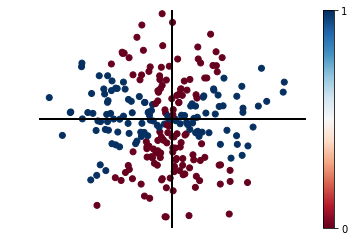

In [5]:
run.plot_results(well_conditioned_results)

In [6]:
matrix = np.asarray([[10.,0.],[0.,-1.]]).astype(np.float32)

num_values_to_try = 250
initial_values_list = [quadratics.generate_initial_values(2) for _ in range(num_values_to_try)]

btls_newton_args = {"method": "newton",
                    "beta":0.5,
                    "alpha" : 0.49,
                    "num_steps": 1,
                    "max_backtrack" : 10}

positive_dominant_results = [run.btls(matrix, initial_values, **btls_newton_args)
              for initial_values in initial_values_list]

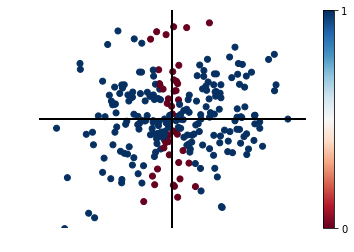

In [7]:
run.plot_results(positive_dominant_results)

In [8]:
matrix = np.asarray([[1.,0.],[0.,-10.]]).astype(np.float32)

num_values_to_try = 250
initial_values_list = [quadratics.generate_initial_values(2) for _ in range(num_values_to_try)]

btls_newton_args = {"method": "newton",
                    "beta":0.5,
                    "alpha" : 0.49,
                    "num_steps": 1,
                    "max_backtrack" : 10}

negative_dominant_results = [run.btls(matrix, initial_values, **btls_newton_args)
              for initial_values in initial_values_list]

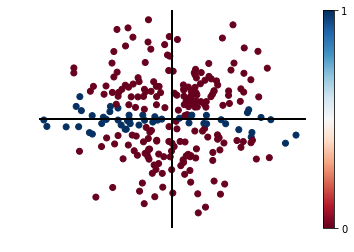

In [9]:
run.plot_results(negative_dominant_results)

### Non-Convex Newton

In [this 2017 arXiV paper](https://arxiv.org/pdf/1707.08028.pdf), Paternain et al. propose a modification to Newton's method for handling non-convex surfaces.

Instead of multiplying the gradient by the inverse of the Hessian, they suggest multiplying the gradient by the "Positive-definite Truncated inverse", or PT-inverse, instead.

This inverse is similar in spirit to a Drazin inverse, but instead of inverting only in the span of non-zero eigenvectors, one inverts only in the span of eigenvectors with eigenvalue greater than some positive threshold. In the span of eigenvectors with negative eigenvalue but with absolute eigenvalue greater than that threshold, one flips the sign of the inverse but otherwise inverts as normal. In the span of eigenvectors with absolute eigenvalue less than the positive threshold, one inverts as though the eigenvectors all had eigenvalue equal to the threshold.

This has the effect of matching the *orientation* of the search direction in each eigenspace to its orientation under gradient descent, while adjusting the *length* of search direction according to curvature information.

In [11]:
matrix = np.asarray([[1.,0.],[0.,-1.]]).astype(np.float32)

num_values_to_try = 250
initial_values_list = [quadratics.generate_initial_values(2) for _ in range(num_values_to_try)]

btls_nc_newton_args = {"method": "nc_newton",
                    "minimum_eigenvalue":0.01,
                    "beta":0.5,
                    "alpha" : 0.49,
                    "num_steps": 1,
                    "max_backtrack" : 10}

well_conditioned_results = [run.btls(matrix, initial_values, **btls_nc_newton_args)
              for initial_values in initial_values_list]

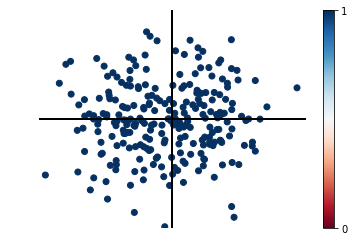

In [12]:
run.plot_results(well_conditioned_results)